In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error



from sklearn.feature_selection import RFE
import statsmodels.formula.api as smf


In [13]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [14]:
#make array with : director_high+director_low+actor_1_high+actor_1_low+actor_2_high+actor_2_low+actor_3_high+actor_3_low
predictors_actors = ['director_high','director_low','actor_1_high','actor_1_low','actor_2_high','actor_2_low','actor_3_high','actor_3_low']
#action + biography + comedy + crime + documentary + drama + history + horror + music + musical + mystery + romance + sport + thriller + war + western
predictors_genre = ['action','biography','comedy','crime','documentary','drama','history','horror','music','musical','mystery','romance','sport','thriller','war','western']
#make logistic model predicting profit_binary from predictors_actors + predictors_genre
logistic_model = smf.logit(formula = 'profit_binary ~ ' + ' + '.join(predictors_actors) + ' + ' + ' + '.join(predictors_genre), data = train).fit()


Optimization terminated successfully.
         Current function value: 0.342461
         Iterations 17


In [15]:
#summary
logistic_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          profit_binary   No. Observations:                 2998
Model:                          Logit   Df Residuals:                     2976
Method:                           MLE   Df Model:                           21
Date:                Sun, 05 Mar 2023   Pseudo R-squ.:                  0.5039
Time:                        23:35:31   Log-Likelihood:                -1026.7
converged:                       True   LL-Null:                       -2069.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.0601   2.24e+06  -2.68e-08      1.000   -4.39e+06    4.39e+06
director_high     0.7491        nan        nan        nan         nan         nan
director_low     -0.8092        nan        nan        nan         nan         nan
actor_1_high      0.3452        nan        nan        nan         nan         nan
actor_1_low      -0.4052        nan        nan        nan         nan         nan
actor_2_high      0.7462        nan        nan        nan         nan         nan
actor_2_low      -0.8062        nan        nan        nan         nan         nan
actor_3_high      1.1746        nan        nan        nan         nan         nan
actor_3_low      -1.2346        nan        nan        nan         nan         nan
action           -0.2639      0.156     -1.694      0.090      -0.569       0.041
biography        -0.1873      0.259     -0.723      0.470      -0.695       0.321
comedy           -0.2164      0.147     -1.477      0.140      -0.504       0.071
crime             0.0883      0.157      0.563      0.574      -0.219       0.396
documentary       1.7499      0.618      2.834      0.005       0.540       2.960
drama             0.0648      0.140      0.462      0.644      -0.210       0.340
history           0.1649      0.315      0.523      0.601      -0.453       0.782
horror            0.5838      0.220      2.654      0.008       0.153       1.015
music             0.0969      0.315      0.308      0.758      -0.520       0.714
musical           0.1952      0.393      0.497      0.619      -0.575       0.966
mystery           0.0995      0.201      0.496      0.620      -0.294       0.493
romance           0.1566      0.143      1.097      0.273      -0.123       0.436
sport            -0.1598      0.291     -0.550      0.582      -0.729       0.410
thriller         -0.1020      0.159     -0.642      0.521      -0.414       0.209
war               0.1247      0.308      0.404      0.686      -0.480       0.729
western          -0.3379      0.499     -0.678      0.498      -1.315       0.639
=================================================================================
"""

In [16]:
#pred on test
test['pred'] = logistic_model.predict(test)

#make binary prediction
test['pred_binary'] = np.where(test['pred'] > 0.5, 1, 0)

In [17]:
#accuracy on test
accuracy = sum(test['pred_binary'] == test['profit_binary'])/len(test)
print(accuracy)

0.8666666666666667


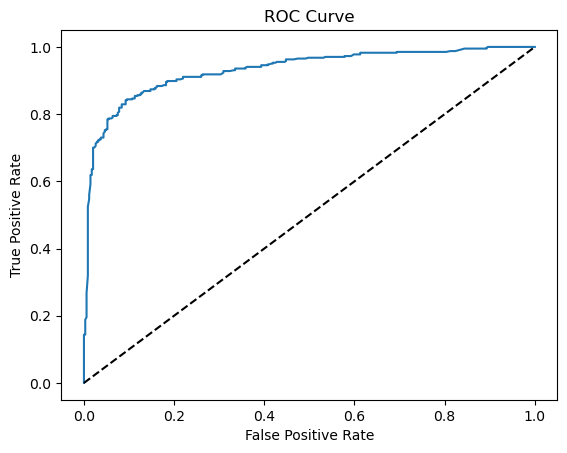

In [18]:
#plot ROC curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(test['profit_binary'], test['pred'])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [22]:
#Function to compute confusion matrix and prediction accuracy on test/train data
from sklearn.metrics import auc


def confusion_matrix_data(data,actual_values,model,cutoff=0.5):
#Predict the values using the Logit model
    pred_values = model.predict(data)
# Specify the bins
    bins=np.array([0,cutoff,1])
#Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
# Calculate the accuracy
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    fnr = (cm[1,0])/(cm[1,0]+cm[1,1])
    precision = (cm[1,1])/(cm[0,1]+cm[1,1])
    fpr = (cm[0,1])/(cm[0,0]+cm[0,1])
    tpr = (cm[1,1])/(cm[1,0]+cm[1,1])
    fpr_roc, tpr_roc, auc_thresholds = roc_curve(actual_values, pred_values)
    auc_value = (auc(fpr_roc, tpr_roc))# AUC of ROC
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    plt.ylabel("Actual Values")
    plt.xlabel("Predicted Values")
    print("Classification accuracy = {:.1%}".format(accuracy))
    print("Precision = {:.1%}".format(precision))
    print("TPR or Recall = {:.1%}".format(tpr))
    print("FNR = {:.1%}".format(fnr))
    print("FPR = {:.1%}".format(fpr))
    print("ROC-AUC = {:.1%}".format(auc_value))


Classification accuracy = 86.7%
Precision = 88.2%
TPR or Recall = 86.9%
FNR = 13.1%
FPR = 13.6%
ROC-AUC = 93.2%


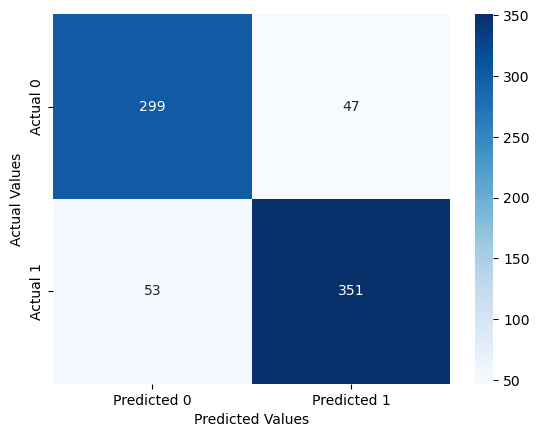

In [23]:
#run confusion_matrix_data like confusion_matrix_data(test,test.Outcome,logit_model_diabetes,0.3)
confusion_matrix_data(test,test.profit_binary,logistic_model,0.5)
